# Klasyfikacja recenzji aplikacji mobilnych

# Podsumowanie

Poniżej przedstawiam wykres metryki zbalansowanej metryki jakości dla testowanych klasyfikatorów. Jak możemy zauważyć, najlepsze wartości osiąga klasyfikator używający LSTM z biblioteki `pytorch`. Co ciekawe, prosty SVM z wygrywa z gęstą siecią neuronową perceptronów, co jest dobrym sygnałem dla metody SVM -- jest też możliwym wynikiem wektoryzacji która wybierała tylko słowa występujące w maksymalnie 95% dokumentów, przez co prawdpodobnie pomijała częste wyrazy nie mające wpływu na treść recenzji.

Dla ostatecznego rozwiązania 58% nie jest bardzo wysokim wynikiem, ale połącznie faktu iż jest to bardzo zbalansowany klasyfikator (57% na metryce zbalansowanej) z praktycznie takim samym wynikiem na zwykłej prezycji może prowadzić do wniosku, iż problem ten jest trudniejszy niż mogłoby się zdawać. Możliwe jest także, iż podobne recenzje posiadają różne wyniki, co prowadziłoby do właśnie takich wyników. 

W celach dalszej poprawy wyników możemy zastosować lepszą metodę wektoryzacji, w szczególności dającą wektory większych rozmiarów. Możliwe jest także zastosowanie trudniejszych architektur do oceny zdań, np. [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)). Innym pomysłem jest także wyuczenie sieci neuronowych do regresji, abyśmy otrzymywali liczbę zmiennoprzecinkową i stosowali odpowednią funckję straty np. [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html?highlight=mse%20loss#torch.nn.MSELoss).

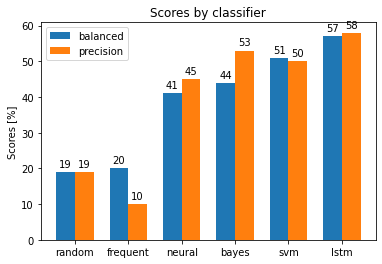

In [31]:
from emd_2.barplot import plot_graph
plot_graph(scores)

## Uruchomienie kodu

Kod do załadowania i uruchomienia modelu końcowego jest dostępny w pliku `validate.py`. Wymagania pythonowe znajdują się w pliku `requirements.txt` i mogą zostać zainstalowane komendą `pip install -r requirements.txt`.

Kod może być wykorzystany dwojako, potrzebujemy jednak pliku `.csv` analogicznego do wejściowego: 

* `python validate.py --input_path input.csv --output_path out.txt`
* `out = get_output(preprocess(load_data('input.csv')))`

W pierwszym z nich, `out.txt` to plik w którym w każdej linii będzie kolejna predykcja.

Druga wersja jest analogiczna do przedstawionej w tym sprawozdaniu i pozwala otrzymać macierz w kodzie, musimy jednak zaimportować kod:

`from validate import get_output, load_data, preprocess`



# Wstęp

## Zbiór danych i jego cechy

Zbiór danych jest zbiorem oceny i opinii na temat aplikacji mobilnych. Został on złączony do zadania jako link. Do jego przetwarzania wykorzystałem paczki widoczne poniżej, a wersja pythona to `3.7.2`.

Paczki:
* pandas
* scikit-learn
* torch

### Ładowanie danych

Ładowanie danych zostało przeprowadzone za pomocą paczki `pandas`, która potrafi ładować dane w formacie `csv`. Warto tutaj dodać, iż dane muszą być na dysku lokalnym -- link do pliku w zadaniu nie jest dostępny z publicznego URL.

In [3]:
def load_data(path: str, delimiter=',', quotechar='"') -> pd.DataFrame:
    return pd.read_csv(path, delimiter=delimiter, quotechar=quotechar)

### Preprocessing danych

Dane posiadają kilkadziesiąt wartości `NaN`, które zostały usunięte. Dodatkowo, atrybut `helpful` został zamieniony na listę dwóch liczb, aby można było na nim wygodnie operować. Atrybut `score` nie został zmieniony na liczbę, gdyż nie ma takiej potrzeby -- jest to na dobrą sprawę 5 różnych klas, gdyż ocena nie może leżeć pomiędzy nimi. Sam preprocessing danych nie jest potrzebny, ze względu na fakt, iż są to dane tekstowe i będą one przetwarzane inaczej dla różnych klasyfikatorów.

In [4]:
def preprocess(data: pd.DataFrame, column_name: str = 'helpful'):
    data[column_name] = data[column_name].apply(lambda x: tuple(json.loads(x)))
    data['score'] = data['score'].astype(str)
    return data.dropna()

### Opis atrybutów

Dane zawierają 9 atrybutów, w tym jeden do klasyfikacji, o nazwie `score`. Należy tutaj zwrócić uwagę na najbardziej obiecujące do nauczania atrybuty: `reviewText` -- zawierający treść recenzji, `summary` -- streszczenie recenzji oraz `helpful` -- ocena jak pomocna była ta opinia. Są one obiecujące, gdyż mają największą szansę być niezależnie wpływające na klasyfikację. Inne atrybuty, takie jak `asin` -- identyfikator aplikacji lub `reviewerID` (albo `reviewerName`, wydają się być tym samym) mogą nam posłużyć do określenia zbiorów uczących i testowych -- tak, aby ta sama aplikacja lub ten sam recenzent nie znajdował się w obu zbiorach uczących, gdyż może to prowadzić do nauczenia się danej aplikacji lub recenzenta, a nie właściwej funkcji oceny. Pozostałe atrybuty, czyli czasu napisania recenzji, zostały pominięte w tej klasyfikacji.

### Podział na zbioru treningowe i testowe

Podział został przeprowadzny za pomocą paczki `scikit-learn`. Zbiór treningowy to około 90% danych, a testowy -- 10%. Warto tutaj także wspomnieć, iż ta sama aplikacja (tj. ten sam atrybut `asin`) nie znajduje się w obu tych zbiorach -- tak, aby dla nowych danych i nowych aplikacji model radził sobie porównywalnie dobrze. Powtarzalność podziału została zapewniona poprzez podanie `random_state`.

### Metryki oceny jakości

Do wszystkich klasyfikacji została zastosawana ta sama metryka jakości: [`balanced_accuracy_score`](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score) z bibliotek `scikit-learn`. Bierze ona pod uwagę każdą klasę tak samo (tak więc oceny od 1.0 do 5.0) i wyciąga z nich ważoną przez ilosć występowania sumę jakości.

In [5]:
def score_metric(y_true, y_pred) -> float:
    return balanced_accuracy_score(y_true, y_pred)

## Klasyfikacja

Faktyczne załadowanie danych widoczne jest poniżej. Następnie widoczne są klasyfikacje na różnych klasyfikatorach dla załadownych danych.

In [6]:
from emd_2.data import split_train_test

X_train, y_train, X_test, y_test = split_train_test(
    preprocess(load_data(DATA_FILEPATH)))

scores = {}

### Klasyfikator większościowy oraz losowy

Przeprowadzone zostały eksperymenty mające na celu ustalenie linii bazowej możliwej jakości klasyfikacji. Wytrenowano klasyfikatory: klasy większościowej oraz losowy (ale uwzględniający rozłożenie atrybutu klasyfikacji `score`) i sprawdzono ich jakość używająć ww. metryki.

In [34]:
dummy_frequent = DummyClassifier(strategy='most_frequent')
dummy_frequent.fit(X_train, y_train)
predictions = dummy_frequent.predict(X_test)
scores['frequent'] = (
    score_metric(y_test, predictions),
    precision_score(y_test, predictions, average='macro'))
score_metric(y_test, predictions)

0.2

In [8]:
dummy_random = DummyClassifier(strategy='stratified')
dummy_random.fit(X_train, y_train)
predictions = dummy_random.predict(X_test)
scores['random'] = (
    score_metric(y_test, predictions),
    precision_score(y_test, predictions, average='macro'))
score_metric(y_test, predictions)

0.19834168318612067

Jak można zauwać, wynik nie jest najlepszy -- co ma sens, gdyż klasyfikator większościowy odgadł tylko 1 z 5 klas (czyli 0.2), a losowy odgadł około 1/5 (dla każdego z przykładów ma szansę około 1/5 iż odgadnie ją prawidłowo gdyż posiada ich rozkład w zbiorze).

### Klasyfikatory sklearn

Wytrenowano dwa klasyfikatory (oraz zoptymalizowane ich parametry przy użyciu [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn-model-selection-halvinggridsearchcv)): SVM oraz klasyfikator bayesa. Do każdego z nich zwektoryzowano dane przy użyciu `TfIdfVectorizer`, który jest często stosowany do klasyfikacji tekstu. Wektoryzator ten przetwarza tekst do macierzy (także może pomijać słowa, które występują zbyt często lub rzadko). Warto wspomnieć, iż użyto tutaj tylko atrybutu `reviewText`.

Co ciekawe, dla obu klasyfikatorów najlepsze parametry wektoryzatora to ngram'y od 1 do 4 słów. Dodatkowo, SVC wybrało tylko słowa pojawiające się w nie więcej niż 95% recenzji.

Kod treningowy dostępny jest w pliku `emd_2/sklearn_models.py`. Pod spodem wczytuje najlepsze modele i otrzymuje wynik predykcji z test setu.

#### SVM

In [9]:
with open('model/sklearn-svc.pkl', 'rb') as out:
    svm = pickle.load(out)

predictions = svm.predict(X_test['reviewText'])
scores['svm'] = (
    score_metric(y_test, predictions),
    precision_score(y_test, predictions, average='macro'))
score_metric(y_test, predictions)

0.5182245998536473

#### Bayes

In [10]:
with open('model/sklearn-bayes.pkl', 'rb') as out:
    bayes = pickle.load(out)
    
predictions = bayes.predict(X_test['reviewText'])
scores['bayes'] = (
    score_metric(y_test, predictions),
    precision_score(y_test, predictions, average='macro'))
score_metric(y_test, predictions)

0.44025788101457286

### Klasyfikator neuronowy

Użyto biblioteki [`pytorch`](https://pytorch.org/) w celu nauczenia modeli neuronowych na karcie graficznej z pamięcią 8 GB. Wszystkie teksty zostały poddane "lowercasowaniu", a wektory słów obliczone za pomocą biblioteki [`spacy`](https://spacy.io/), gdzie długość jednego tokenu dla wyrazu to 96. 

Funkcja straty została dopasowana do problemu -- jest to cross entropia pomnożona o odległość od poprawnej klasy, co zapewnia większą stratę klasyfikatora jeśli predykcja jest bardzo różna od wyniku recenzji. Dodatkowo zostały podane wagi poszczególnych klas w celu polepszenia klasyfikacji każdej z nich -- wagi te są odwrotnością znormalizowanej macierzy ich występowania w zbiorze treningowym.

Wyuczono dwa modele, jeden podstawowy, drugi oparty na architekturze LSTM. Kod treningowy dostępny jest w pliku `emd_2/neural_models.py`. Pod spodem wczytuje najlepsze wagi i dokonuję predykcji.

#### Basic Perceptrons:
Podstwowa sieć neuronowa ma wymiary (193, 32, 5), gdyż do pierwszej warstwy podajemy 2 wektory, odpowiednio dla recenzji i podsumowania oraz jedną ocenę tej recenzji jako wartość znormalizowaną.

In [11]:
from validate import get_output

predictions = get_output(X_test, 'model/basic-net.pt', basic=True)
scores['neural'] = (
    score_metric(y_test, predictions),
    precision_score(y_test, predictions, average='macro'))
score_metric(y_test, predictions)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53306/53306 [16:42<00:00, 53.15it/s]


0.4162698145114847

#### LSTM:



Sieć LSTM jest bardziej skomplikowana, posiada w sobie dwie sieci LSTM, jedną do recenzji (posiadająca 4 warstwy) i podsumowania (posiadająca 2 warstwy). Obie z nich to sieci dwukierunkowe, z wielkością warstwy ukrytej równej 32. Po przetworzeniu tokenów (które muszą być padowane do rozmiarów maksymalnego) przez LSTM, wartości z obu sieci ukrytych trafiają do gęstej sieci perceptronów o wymiarach (4 * 32, 32, 5). Mnożenie razy 4 wynika z faktu dwukierunkowej sieci.


In [12]:
from validate import get_output

predictions = get_output(X_test, 'model/lstm-net.pt')
scores['lstm'] = (
    score_metric(y_test, predictions),
    precision_score(y_test, predictions, average='macro'))
score_metric(y_test, predictions)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53306/53306 [54:32<00:00, 16.29it/s]


0.5718478884577464